# Flat Fielding with Bias Correction

In this notebook, we extract the flat flux from the relevant files; such files are the ones with the data product type designeted as 'LIGHT LIGHT TUN', meaning that the CCD in those frames is illuminated with tungsten lamp, meaning uniform illumination across the CCD. The idea is that we can now measure the flux in each pixels to find the pixel response to the uniform light. Since one provides the uniform illumination such frames are called the 'flats'. We, later, want to correct our science images for the flats: the idea to do this is to make the pixel response to the light uniform over the CCD.

We first want to list all of the flat files, then we identify the 104th order and the bias region. Below, we make a list of all flat files and visualize one of them. We first work on this single flat file and then shall generalise the process for all of the flat files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from astropy.io import fits
from scipy.optimize import curve_fit as cft
import os
import utils as utl
import order_id as oid

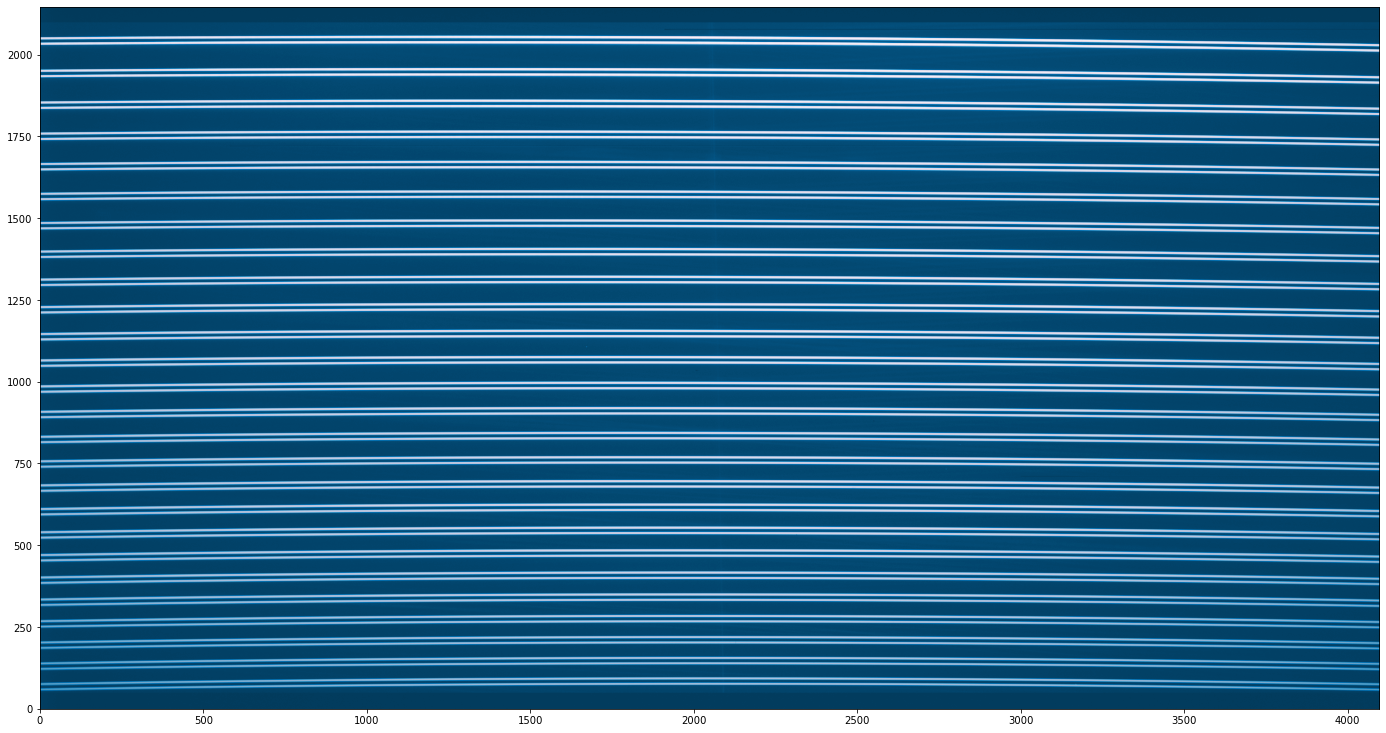

In [2]:
p1 = os.getcwd() + '/Spectro-Module/raw/'
list_all = os.listdir(p1)
list_flat = np.array([])

for i in range(len(list_all)):
    hdul = fits.open(p1 + list_all[i])
    h11 = hdul[0].header
    if h11['HIERARCH ESO DPR TYPE'] == 'LAMP,LAMP,TUN':
        list_flat = np.hstack((list_flat, list_all[i]))

fla1 = fits.open(p1 + list_flat[0])
fla2 = fla1[2].data
fla3 = np.transpose(fla2)
plt.figure(figsize=(16*1.5, 9*1.5))
plt.imshow(fla3, origin='lower', norm=clr.LogNorm(),cmap='PuBu_r')

## Bias and Read noise estimation

The top 50 rows (top in the sense that edge towards higher orders) in above image represents the overscan region, meaning the region which is not exposed to the light. We use this 50 rows to estimate the bias (mean value of counts in these pixels) and read noise (scatter of counts). We first extract the data in these 50 rows, flatten the data and find the mean and the standard deviation of them. We also visualise this region.

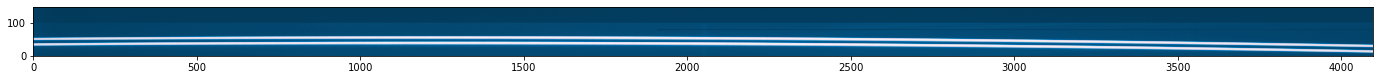

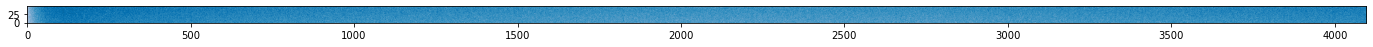

In [3]:
bias_data1 = fla3[1998:]
bias_data = fla3[2098:]

plt.figure(figsize=(16*1.5, 9*1.5))
plt.imshow(bias_data1, origin='lower', norm=clr.LogNorm(),cmap='PuBu_r')
plt.show()
plt.figure(figsize=(16*1.5, 9*1.5))
plt.imshow(bias_data, origin='lower', norm=clr.LogNorm(),cmap='PuBu_r')

In above figure, one can see the last order and the darker region towards the edges. This 'darker' region is nothing but the overscan region, from which we want to find the mean and scatter in the data. Which we do below. The overscan region only is shown in the second figure above. One thing to remember is that what we will count from these data would be ADU, which we want to convert into units of 'electrons' using the conversion factor 1.42 e-/ADU.

In [4]:
bias_data2 = np.ndarray.flatten(bias_data)
bias_0 = np.mean(bias_data2)*1.42
std_0 = np.std(bias_data2)*1.42

print('Bias and Read noise:')
print('--------------------')
print('Bias is: ' + str(bias_0) + ' e-')
print('Read noise is: ' + str(std_0) + ' e-')

Bias and Read noise:
--------------------
Bias is: 270.10482158203126 e-
Read noise is: 5.836710876166139 e-


We want to subtract this bias from each of the flux values in this CCD. We shall calculate the bias for each frames later. The read noise calculated here would be added to the photon noise later to find the total uncertainty in the measurement.

## Order Identification and Flux Extraction

We now use the coefficients of polynomial calculated earlier in other notebook to find the location of 104th order on the frame. Then we shall determine the number of pixels around this position to sum up to find the flux in this order. Before that, first identify the location of the order and visualize it.

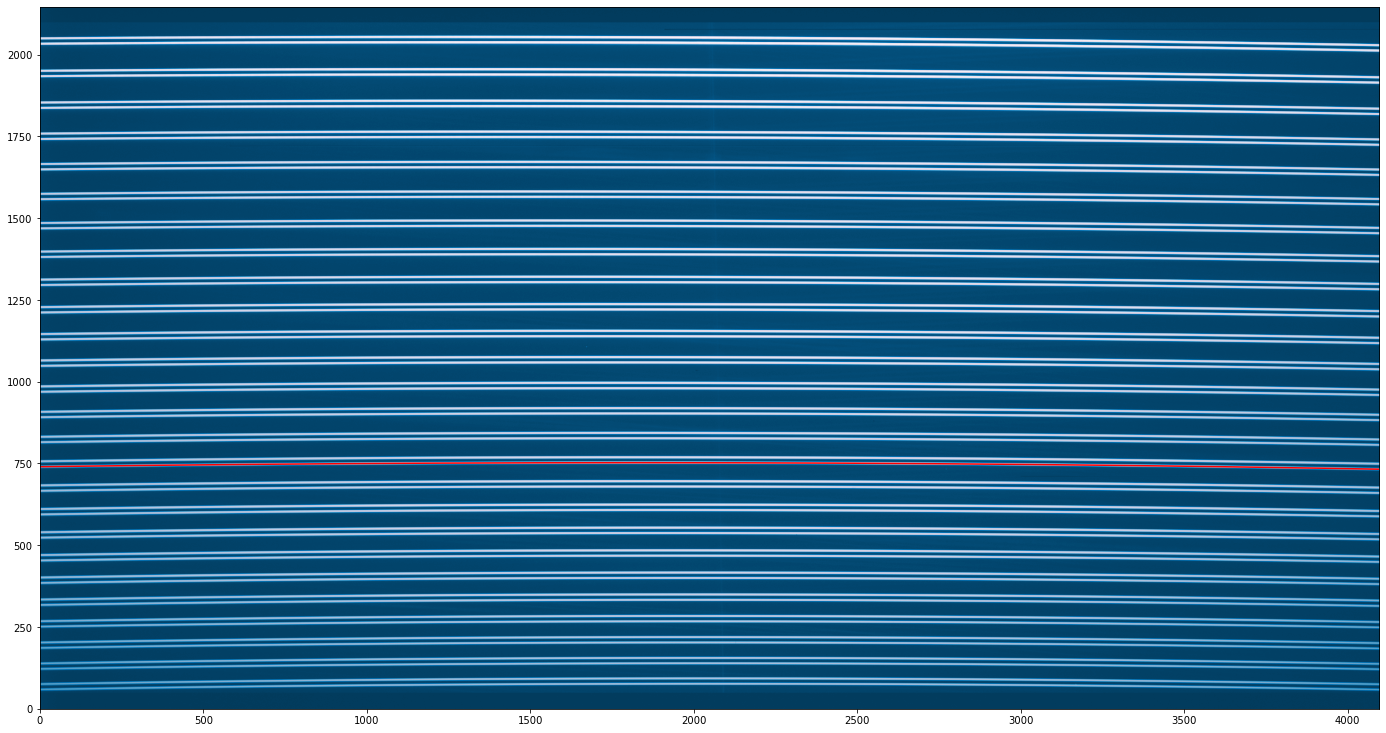

In [5]:
popt1 = np.array([1.49453189e+01, 1.33410596e-02, -3.52806113e-06, -4.42031001e-11])
xdata = np.arange(len(fla3[0]))
ydata = utl.cubic_104(xdata, *popt1)

plt.figure(figsize=(16*1.5, 9*1.5))
plt.imshow(fla3, origin='lower', norm=clr.LogNorm(),cmap='PuBu_r')
plt.plot(xdata, ydata, c='red')

It is evident from above figure that the position of the 104th order is well located. Now, we want to determine how many pixels around this location we want to use in the summation in order to find the flux. To do this, let's first plot the cross-section at some random x-axis value. We shall, for now, use 25 and 7 pixels below and above the identified position to determine the optimum value.

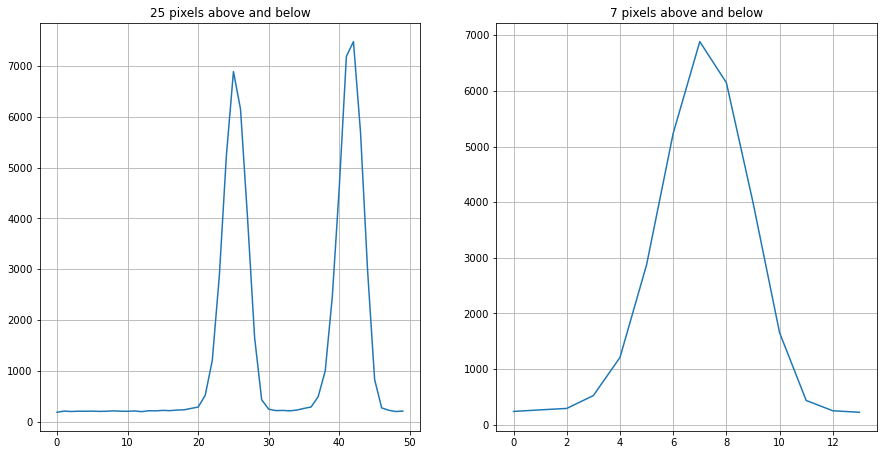

In [6]:
xposi = 100#np.random.randint(1,4000)
data_104_25 = fla3[int(ydata[xposi])-25:int(ydata[xposi]+25), xposi]
data_104_7 = fla3[int(ydata[xposi])-7:int(ydata[xposi]+7), xposi]

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))
ax0.plot(data_104_25)
ax0.set_title('25 pixels above and below')
ax0.grid()
ax1.plot(data_104_7)
ax1.set_title('7 pixels above and below')
ax1.grid()

It is clear from above figure that 25 pixels above and below of the identified positions would be too much spread in the cross-section --- it would even include the second chanel. To avoid this, we can use only 7 pixels above and below of the identified position of the order and sum over this 14 pixels to find the flux at that x-value of the order.

So let's do this for a whole range of the order. Remember that we need to subtract the bias.

In [7]:
flux_flat = np.array([])
flux_err = np.array([])

for i in range(len(ydata)):
    data = (fla3[int(ydata[i])-7:int(ydata[i]+7), i])*1.42
    data1 = data - bias_0
    flx = np.sum(data1)
    flux_flat = np.hstack((flux_flat, flx))
    photon_noise = np.sqrt(flx)
    tot_noise = np.sqrt(photon_noise**2 + std_0**2)
    flux_err = np.hstack((flux_err, tot_noise))

Let's plot the flat and see how it looks.

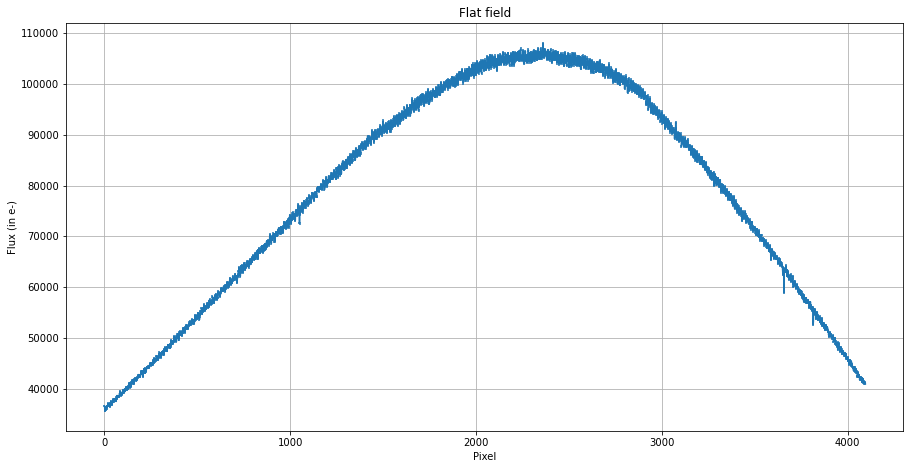

In [8]:
plt.figure(figsize=(15,7.5))
plt.errorbar(xdata, flux_flat, yerr=flux_err)
plt.xlabel('Pixel')
plt.ylabel('Flux (in e-)')
plt.title('Flat field')
plt.grid()

## Repeating the same procedure for all of the flats

We, thus, estimated the flux for one of the flats (namely the first in the `list_flat`). Already performed steps are:
- reading fits data
- bias and read noise estimation
- order identification
- sum up the counts in 14 pixels around the identified order

We want to repeat the same procedure for rest of the flat files in `list_flat`.

In [9]:
flux_flat_n = np.copy(flux_flat)
flux_err_n = np.copy(flux_err)

for j in range(len(list_flat)-1):
    # Reading fits data
    fla1_n = fits.open(p1 + list_flat[j+1])
    fla2_n = fla1_n[2].data
    fla3_n = np.transpose(fla2_n)
    # Bias and Read noise estimation
    bias_data_n = fla3_n[2098:]
    bias_data2n = np.ndarray.flatten(bias_data_n)
    bias_n = np.mean(bias_data2n)*1.42
    std_n = np.std(bias_data2n)*1.42
    # Order identification
    xdata_n = np.arange(len(fla3_n[0]))
    ydata_n = utl.cubic_104(xdata_n, *popt1)
    # Counting flux and error in flux
    dummy_flux = np.array([])
    dummy_flux_err = np.array([])
    for i in range(len(ydata)):
        data_n = (fla3_n[int(ydata_n[i])-7:int(ydata_n[i]+7), i])*1.42
        data1n = data_n - bias_n
        flxn = np.sum(data1n)
        dummy_flux = np.hstack((dummy_flux, flxn))
        photon_noise1 = np.sqrt(flxn)
        tot_noise1 = np.sqrt(photon_noise1**2 + std_n**2)
        dummy_flux_err = np.hstack((dummy_flux_err, tot_noise1))
    flux_flat_n = np.vstack((flux_flat_n, dummy_flux))
    flux_err_n = np.vstack((flux_err_n, dummy_flux_err))

## Stacking flats

The `flux_flat_n` and `flux_err_n` contains the flux and errors in flux for all of the files, respectively. Now, we want to stack these fluxes while propogating errors correctly. We can either sum all of these fluxes in order to stack them; or we can averange them and later normalize them. We try both; first we simply add all of the frames to find the stacked flux, and then we try to find normalized average stacked flux.

Text(0.5, 1.0, 'Stacked flats')

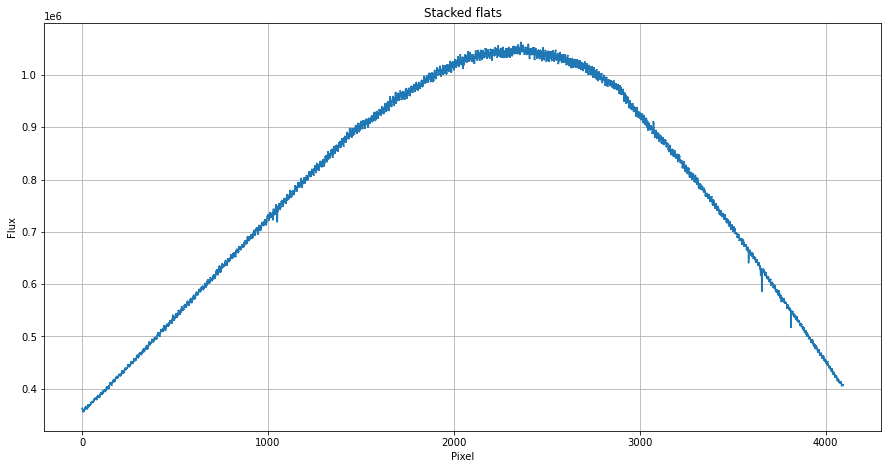

In [10]:
flux_stacked_sum = np.sum(flux_flat_n, axis=0)
flux_err_stacked_sum = np.sqrt(np.sum(flux_err_n**2, axis=0))

f1 = open(os.getcwd() + '/Results/flat_stacked_sum.dat', 'w')
f1.write('#Pixel\t\t Flux\t\t Err\n')
for i in range(len(flux_stacked_sum)):
    f1.write(str(xdata[i]) + '\t' + str(flux_stacked_sum[i]) + '\t' + str(flux_err_stacked_sum[i]) + '\n')

f1.close()

plt.figure(figsize=(15, 7.5))
plt.errorbar(xdata, flux_stacked_sum, yerr=flux_err_stacked_sum)
plt.xlabel('Pixel')
plt.ylabel('Flux')
plt.grid()
plt.title('Stacked flats')

Or what can we do is to use another way to stack frames: that is to average them. Let's do this now.

Text(0.5, 1.0, 'Stacked flats')

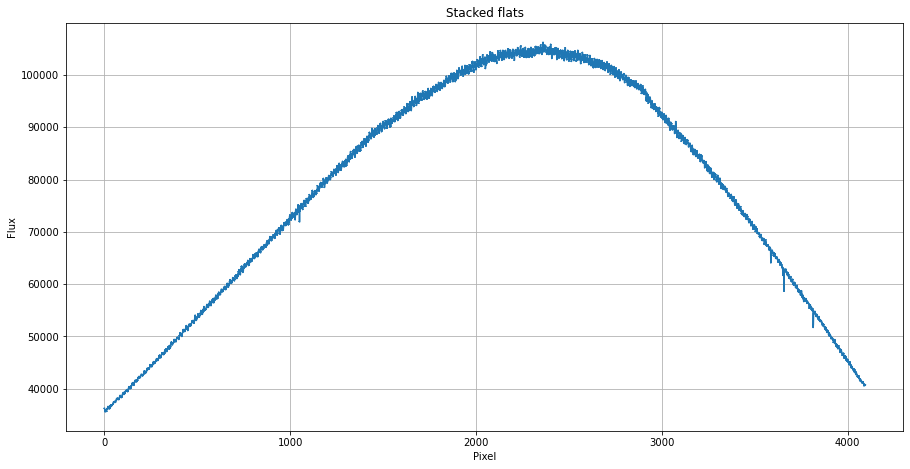

In [11]:
flux_stacked_avg = np.mean(flux_flat_n, axis=0)
flux_err_stacked_avg = np.sqrt(np.sum(flux_err_n**2, axis=0))/10

f2 = open(os.getcwd() + '/Results/flux_stacked_avg.dat', 'w')
f2.write('#Pixel\t\t Flux\t\t Err\n')
for i in range(len(flux_stacked_sum)):
    f2.write(str(xdata[i]) + '\t' + str(flux_stacked_avg[i]) + '\t' + str(flux_err_stacked_avg[i]) + '\n')

f2.close()

plt.figure(figsize=(15, 7.5))
plt.errorbar(xdata, flux_stacked_avg, yerr=flux_err_stacked_avg)
plt.xlabel('Pixel')
plt.ylabel('Flux')
plt.grid()
plt.title('Stacked flats')